In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import scipy.signal as signal
import librosa


sys.path.append("/Users/oscarjimenezbou/Library/Mobile Documents/com~apple~CloudDocs/Documents/University_projects/TDS"
                )

In [2]:
from scipy.io import wavfile
from scipy.stats import kurtosis
from scipy.fft import fft
from utils import *

#### Inicialización
- Definimos la duración de cada trama y el solape:
- Duración de cada trama: 32ms
- Solape del 50%

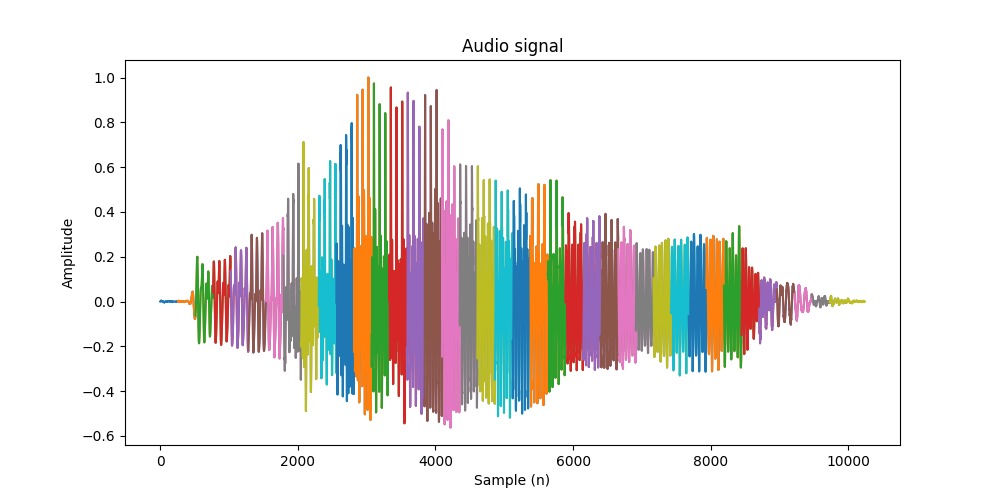

In [3]:
'''
- Extract the audio signal from the wav file and plot it
- normalize and convert the audio signal to mono
- trim the audio signal
- split the singnal and plot it
- calculate the FFT of the signal
'''

%matplotlib widget
frequency_audio, audio = wavfile.read("nine.wav")

audio = audio / np.max(np.abs(audio))

yt, index = librosa.effects.trim(
    audio, top_db=20, frame_length=2048, hop_length=512)

audio = audio[index[0]:index[1]] # convert to mono

audio_frames = cut_signal_frames(audio, frequency_audio, tiempo_frames=0.032, overlap=0.5)
samples = cut_signal_frames([i for i in range(len(audio))], frequency_audio, tiempo_frames=0.032, overlap=0.5)

plt.figure(figsize=(10, 5))
for i in range(0, len(audio_frames)):
    plt.plot(samples[i], audio_frames[i])
    plt.title("Audio signal")
    plt.xlabel("Sample (n)")
    plt.ylabel("Amplitude")
plt.show()

#### Calcular los MFCC (__Mel Frequency Cepstral Coefficients__)


In [4]:
MFCCC = librosa.feature.mfcc(y=audio, sr=frequency_audio, n_mfcc=13)
TMFCC = np.transpose(MFCCC)  # transpose the matrix

#### Calcular Spectral Flux y Spectral Centroid

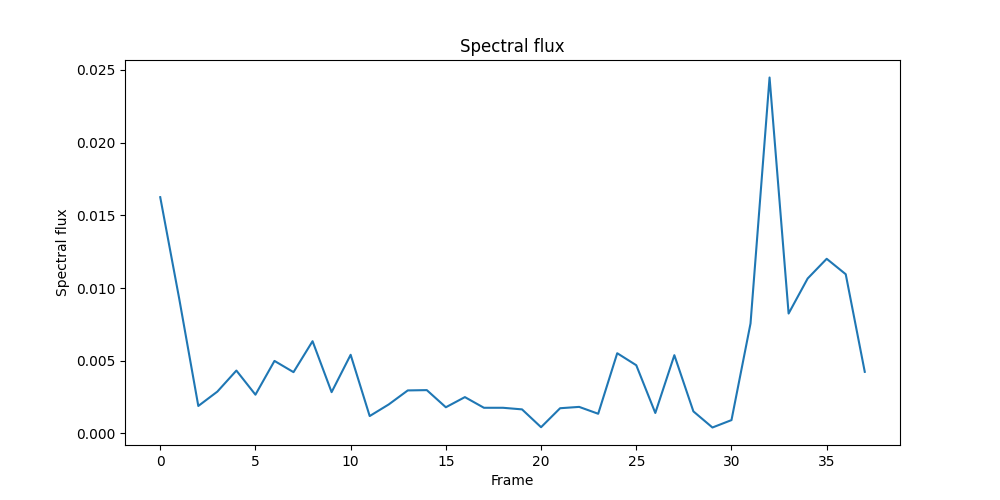

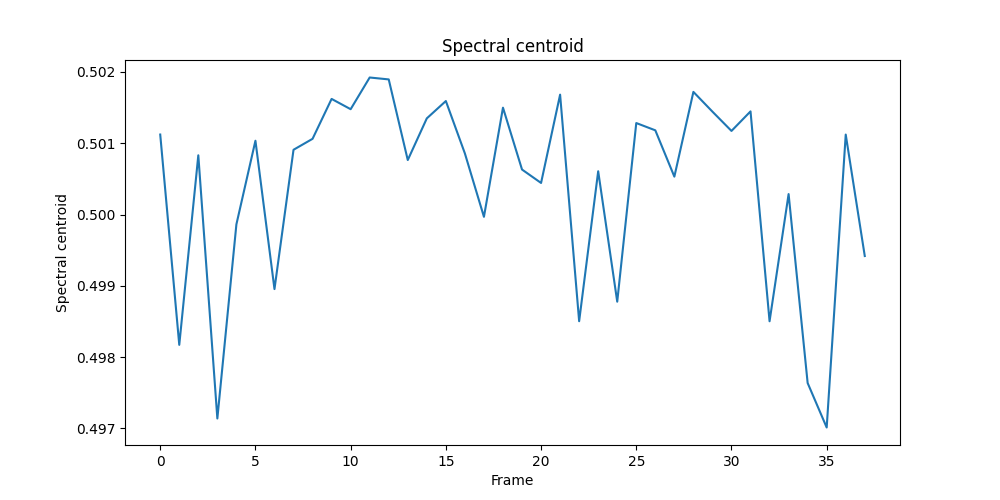

In [5]:
epsilon = sys.float_info.epsilon


def spectral_centroid_spread(fft_magnitude, sampling_rate):
    """
    Computes spectral centroid of frame (given abs(FFT)) and spread of the frame.
    It provides an idea of where the "brightness" or "density" of a sound signal is concentrated. 
    It indicates the "center of gravity" of the frequency spectrum of a signal

    ARGUMENTS:
        fft_magnitude:            abs(FFT) of the signal
        sampling_rate:            the sampling freq (needed to obtain the frequency vector)

    RETURNS:    
        a tuple (centroid, spread)
        centroid:    spectral centroid
        spread:        spectral spread
    """
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt_max = Xt.max()
    if Xt_max == 0:
        Xt = Xt / epsilon
    else:
        Xt = Xt / Xt_max

    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + epsilon

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    """
    Measures the amount of change in the power spectrum of a signal from one frame to another
    Must to use frame by frame (not in the whole signal)
    ARGUMENTS:
        fft_magnitude:            the abs(fft) of the current frame
        previous_fft_magnitude:        the abs(fft) of the previous frame

    RETURNS:
        the spectral flux feature value of the current frame 
    """
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + epsilon)
    previous_fft_sum = np.sum(previous_fft_magnitude + epsilon)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


spectral_fluxes = []
spectral_centroids = []
spectral_spreads = []

for i in range(1, len(audio_frames)):
    previous_fft = np.abs(np.fft.fft(audio_frames[i - 1]))
    fft = np.abs(np.fft.fft(audio_frames[i]))
    spectral_fluxes.append(spectral_flux(fft, previous_fft))
    centroid, spread = spectral_centroid_spread(fft, frequency_audio)
    spectral_centroids.append(centroid)
    spectral_spreads.append(spread)

plt.figure(figsize=(10, 5))
plt.plot(spectral_fluxes)
plt.title("Spectral flux")
plt.xlabel("Frame")
plt.ylabel("Spectral flux")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(spectral_centroids)
plt.title("Spectral centroid")
plt.xlabel("Frame")
plt.ylabel("Spectral centroid")
plt.show()

#### Create Function ObtainCharacteristics

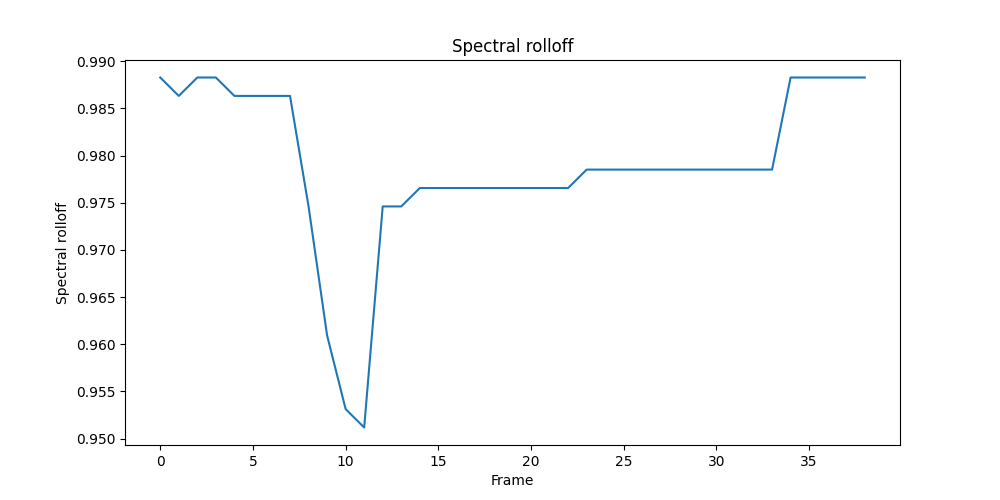

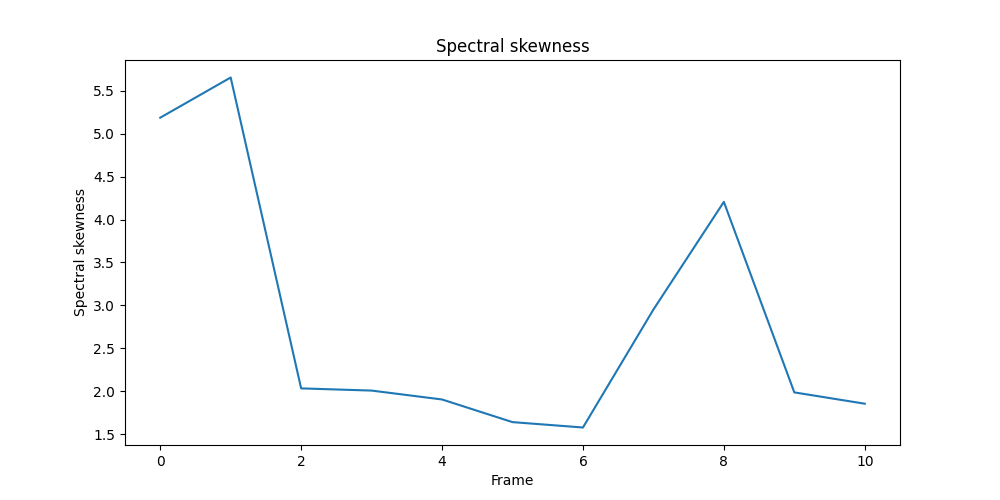

In [6]:

import librosa
from scipy.stats import skew
import numpy as np
features = []

MFCC_delta = librosa.feature.delta(MFCCC)

features.append(MFCCC)
features.append(MFCC_delta)
features.append(spectral_fluxes)
features.append(spectral_centroids)
features.append(spectral_spreads)


def spectral_rolloff(signal, c):
    """Computes spectral roll-off"""

    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + epsilon
    # find the first index where the cumulative sum is greater than the threshold
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff


spectral_rolloffs = []
for i in range(0, len(audio_frames)):
    fft = np.abs(np.fft.fft(audio_frames[i]))
    spectral_rolloffs.append(spectral_rolloff(fft, 0.85))  # 85% of the energy

features.append(spectral_rolloffs)

plt.figure(figsize=(10, 5))
plt.plot(spectral_rolloffs)
plt.title("Spectral rolloff")
plt.xlabel("Frame")
plt.ylabel("Spectral rolloff")
plt.show()


def spectral_skewness(y, sr, frame_length=2048, hop_length=1024):
    # Calcular la STFT
    S = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))

    # Calcular frecuencias para cada bin
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=frame_length)

    # Calcular el centroide espectral
    mu_1 = librosa.feature.spectral_centroid(
        S=S, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]

    # Calcular la dispersión espectral (espectro de potencia)
    mu_2 = librosa.feature.spectral_bandwidth(
        S=S, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]

    # Preparar la asimetría espectral
    skewness = []
    for t in range(S.shape[1]):
        # Suma ponderada de las desviaciones cúbicas del centroide, normalizada por la dispersión al cubo
        num = np.sum((frequencies - mu_1[t])**3 * S[:, t])
        den = (mu_2[t]**3) * np.sum(S[:, t])
        skew = num / den if den != 0 else 0
        skewness.append(skew)

    return skewness


skewness = spectral_skewness(audio, frequency_audio)

features.append(skewness)

plt.figure(figsize=(10, 5))
plt.plot(skewness)
plt.title("Spectral skewness")
plt.xlabel("Frame")
plt.ylabel("Spectral skewness")
plt.show()